In [0]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# The next two cells are used to read all the NHS data into a dictionary

In [0]:
# Run this ONLY IF YOU USE GOOGLE COLAB
google_drive_dir = 'ai_hack_2020'

try:
    from google.colab import drive
    drive.mount("/content/drive", force_remount=True)
    directory = "working_dir"
    if not os.path.exists(directory):
      os.symlink(os.path.join("drive", "My Drive", google_drive_dir), directory)
except ModuleNotFoundError as err:
    print("This only works on Google Colab. Skipping ...")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# # Load the data (will take a short while)
# data = {}
# for file in os.listdir("drive/My Drive/ai_hack_2020/nhs_data"):
#     if file[-4:] != ".csv":
#         continue
#     if file in ["INDICATOR_MAPPINGS.csv", "CCG_EXCEPTIONS_EXCLUSIONS.csv"]:
#         continue
#     # print("Loading {} ...".format(file))
#     data[file[:-4]] = pd.read_csv("drive/My Drive/ai_hack_2020/nhs_data/{}".format(file))
# print("Done!")

## Begin the analysis

In [0]:
import requests
import json
import re

In [0]:
#let's see if we can read the BNF
ds = pd.read_csv("drive/My Drive/ai_hack_2020/nhs_data/bnf_sections.csv") #desease section

In [0]:
ds.shape

(521, 6)

In [0]:
cn = ds.code_name

In [0]:
#we can to see which of these indicators have anything to do with lunch cancer
names = list(cn)
print(names)
#for this we are going to need reqular expressions

['Gastro-Intestinal System', 'Dyspep&Gastro-Oesophageal Reflux Disease', 'Antacids and Simeticone', 'Compound Alginates&Prop Indigestion Prep', 'Antispasmod.&Other Drgs Alt.Gut Motility', 'Antisecretory Drugs+Mucosal Protectants', 'H2-Receptor Antagonists', 'Selective Antimuscarinics', 'Chelates And Complexes', 'Prostaglandin Analogues', 'Proton Pump Inhibitors', 'Acute Diarrhoea', 'Adsorbents And Bulk-Forming Drugs', 'Antimotility Drugs', 'Enkephalinase Inhibitors', 'Tryptophan Hydroxylase Inhibitors', 'Chronic Bowel Disorders', 'Aminosalicylates', 'Corticosteroids', 'Drugs Affecting Immune Response', 'Food Allergy', 'Laxatives', 'Bulk-Forming Laxatives', 'Stimulant Laxatives', 'Faecal Softeners', 'Osmotic Laxatives', 'Bowel Cleansing Preparations', 'Peripheral Opioid-Receptor Antagonists', 'Other Drugs Used In Constipation', 'Local Prepn for Anal & Rectal Disorders', 'Soothing Haemorrhoidal Preparations', "Co Haemorrhoidal Prep's + Corticosteroid", 'Rectal Sclerosants', 'Management o

## Find Chemicals Approved for None-Small Cell Lung Cancer Treatment

In [0]:
#we need to scrape the webpage giving the lung cancer drugs
req = requests.get("https://www.cancer.gov/about-cancer/treatment/drugs/lung")
print(req.status_code)

200


In [0]:
from bs4 import BeautifulSoup

soup = BeautifulSoup(req.text, 'html.parser')
drugs = soup.find("section", {"id": "1"})
list1 = drugs.select("li > a")

In [0]:
drugs = [x.contents[0].split(" ") for x in list1]
d = []
for i in drugs[:-1]: #the last entry is empty
  for j in i:
    j = j.replace("(","")
    j = j.replace(")","")
    d.append(j)

In [0]:
d[-2:]

['Zykadia', 'Ceritinib']

In [0]:
#we now need to search our BNF list 

#we need to make a list of reqular expressions


## Scrape the Codes of All Chemicals



In [0]:
req = requests.get("https://openprescribing.net/chemical/")
soup = BeautifulSoup(req.text, 'html.parser')

In [0]:
drugs = soup.find("ul", {"id": "all-results"})
list1 = drugs.select("li")
numbers = [x.contents[-1] for x in list1]

list1 = drugs.select("li > a")
chemical = [x.contents[0] for x in list1]

In [0]:
numbers[:4] #codes of all chemicals
chemical[:4] #names of all chemicals

#save these:
number_chemical = np.vstack([numbers,chemical])
np.save("working_dir/saved_arrays/code_chemical",number_chemical)

In [0]:
#chemical

In [0]:
cancer_chems = []
#loop through all drugs:
for c in chemical:
  #create a regular expression
  if c == "":
    continue
  try:  
    re_temp = re.compile(".*"+str(c)+".*")
    #print(re_temp)
  except:
    continue
  for drug,number in zip(d,numbers):
    try:
      p = re_temp.match(drug).group()
      #print(p)
      cancer_chems.append((drug,number))
    except:
      pass

In [0]:
#cancer_chems
#make a dictionary out of the cancer chemicals
code_to_chem = {}
for name,code in cancer_chems:
  code = code.replace("(","")
  code = code.replace(")","")
  code = code.replace(" ","")
  code_to_chem[code] = name

chem_to_code = {}
for name,code in cancer_chems:
  code = code.replace("(","")
  code = code.replace(")","")
  code = code.replace(" ","")
  chem_to_code[name] = code

In [0]:
code_to_chem

{'0101010E0': 'Paclitaxel',
 '0101010J0': 'Afatinib',
 '0101010P0': 'Everolimus',
 '0102000AK': 'Carboplatin',
 '0102000L0': 'Dabrafenib',
 '0102000R0': 'Docetaxel',
 '0103010D0': 'Erlotinib',
 '0103010N0': 'Everolimus',
 '0103010S0': 'Gefitinib',
 '0103020P0': 'Afatinib',
 '010401000': 'Gefitinib',
 '0105010C0': 'Trametinib',
 '0105010D0': 'Methotrexate',
 '0106010N0': 'Osimertinib',
 '0106020B0': 'Paclitaxel',
 '0106020C0': 'Paclitaxel',
 '0106020M0': 'Carboplatin',
 '0106020U0': 'Carboplatin',
 '0106040R0': 'Dabrafenib',
 '0106050M0': 'Osimertinib',
 '0106060A0': 'Erlotinib',
 '0106070B0': 'Paclitaxel',
 '010701000': 'Docetaxel',
 '0107010E0': 'Trametinib',
 '0107010I0': 'Methotrexate'}

## Try the API

Even though we have the data for the different BNFs we do not have it for individual chemicals. We can however get them using the API of openprescibing.


In [0]:
#req = requests.get("https://openprescribing.net/api/1.0/spending/?code=0107010I0&format=csv")#

req = requests.get("https://openprescribing.net/api/1.0/spending/?code=0101010E0&format=csv")

In [0]:
(reg.status_code)

200

In [0]:
req.text

''

In [0]:
d = req.text.split()
#d = [x.split() for x in d]

In [0]:
d

[]

In [0]:
heads = d[0]
print(heads)


IndexError: ignored

In [0]:
#d

In [0]:
data = d[1:]
n = len(data)
k = len(data[0].split(","))
print(n,k)

60 4


In [0]:
actual_cost,date,items,quantity = [],[],[],[]
for i in range(n):
  data_temp = data[i].split(",")
  actual_cost.append(data_temp[0])
  date.append(data_temp[1])
  items.append(data_temp[2])
  quantity.append(float(data_temp[3]))
    

2015-01-01 2019-12-01


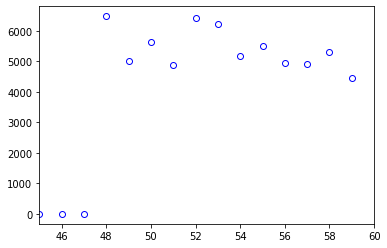

In [0]:
plt.plot(quantity,"o",color = "blue",fillstyle = "none")
plt.xlim(45,60)
print(date[0],date[-1])

## Chemicals for Drugs Approved for Non-Small Cell Lung Cancer

In [0]:
#recast the above into a function

def read_chemical(chem_code):

  """
  This function takes the code of a given chemical and returns four columns 
  named actual_cost,date,items, and quantity.
  """

  req = requests.get("https://openprescribing.net/api/1.0/spending/?code="+\
                     str(chem_code)+"&format=csv")
  print(req.status_code)

  if req.text == '':
    print("No Data")
    return None,None,None,None

  d = req.text.split()


  data = d[1:]
  n = len(data)
  k = len(data[0].split(","))
  actual_cost,date,items,quantity = [],[],[],[]
  
  for i in range(n):
    data_temp = data[i].split(",")
    actual_cost.append(data_temp[0])
    date.append(data_temp[1])
    items.append(data_temp[2])
    quantity.append(float(data_temp[3]))

  return actual_cost,date,items,quantity

In [0]:
code = '0101010E0'
actual_cost,date,items,quantity = read_chemical(code)

200
No Data


In [0]:
#we can now try to do this for all available chemicals
codes = code_to_chem.keys()
chemical_data_dict = {}

for c in codes:

  actual_cost,date,items,quantity = read_chemical(c)

  if date == None:
    next
  else:
    temp_dict = {}
    temp_dict["actual_cost"] = actual_cost                                                 
    temp_dict["date"] = date              
    temp_dict["items"] = items
    temp_dict["quantity"] =   quantity                                   
    chemical_data_dict[c] = temp_dict



200
200
200
200
200
200
No Data
200
200
200
200
200
200
200
200
200
200
200
200
200
200
No Data
200
200
200
200
200


In [0]:
qlist = []
i = -1
for chemical in chemical_data_dict.keys():
  i+=1
  value_dict = chemical_data_dict[chemical]
  qlist.append(np.array(value_dict["quantity"]))

qq = np.vstack(qlist)

In [0]:
qmax = np.repeat(np.max(qq,axis = 1).reshape(23,1),60,axis = 1)

2015-01-01 2019-12-01


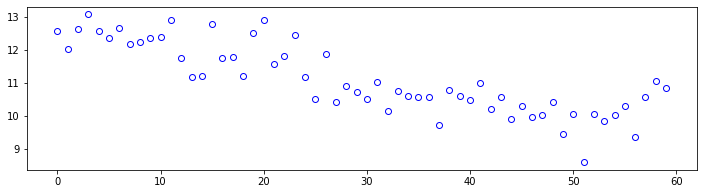

In [0]:
#sub

plt.figure(figsize = (12,3))
plt.plot(np.sum(qq/qmax,axis = 0),"o",color = "blue",fillstyle = "none")
#plt.xlim(45,60)
print(date[0],date[-1])

In [0]:
#let's try some fitting

from sklearn.kernel_ridge import KernelRidge

clf = KernelRidge(alpha=100)
X = np.arange(0,60,1)[:, np.newaxis]
y= np.sum(qq/qmax,axis = 0)
clf.fit(X, y)

KernelRidge(alpha=100, coef0=1, degree=3, gamma=None, kernel='linear',
            kernel_params=None)

In [0]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import numpy as np
model = Pipeline([('poly', PolynomialFeatures(degree=5)),
                   ('linear', LinearRegression(fit_intercept=False))])
model = model.fit(X, y)

In [0]:
y_pred = model.predict(X)

2015-01-01 2019-12-01


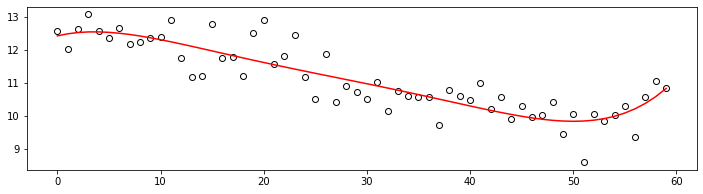

In [0]:
plt.figure(figsize = (12,3))
plt.plot(X,y,"o",color = "black",fillstyle = "none")
plt.plot(X,y_pred,"-",color = "red",fillstyle = "none")

#plt.xlim(45,60)
print(date[0],date[-1])

In [0]:
from scipy.interpolate import UnivariateSpline

fit = UnivariateSpline(X,y, k =5)

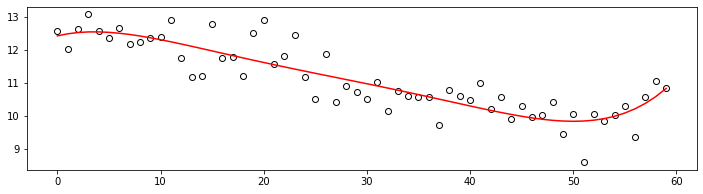

In [0]:
plt.figure(figsize = (12,3))
plt.plot(X,y,"o",color = "black",fillstyle = "none")
plt.plot(X,fit(X),"-",color = "red",fillstyle = "none")

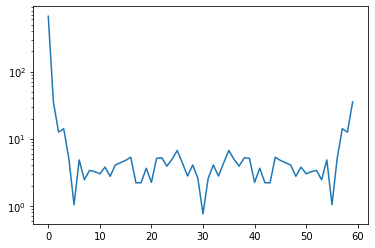

In [0]:
from numpy import fft

y_freq = np.absolute(np.fft.fft(y))
y_fred = np.fft.fftshift(y_freq)

plt.semilogy(y_freq,"-")

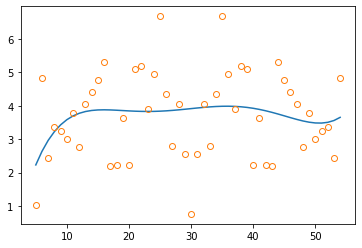

In [0]:
plt.plot(X_omega,model.predict(X_omega))
plt.plot(X_omega,y_freq[X_omega],"o",fillstyle = "none")

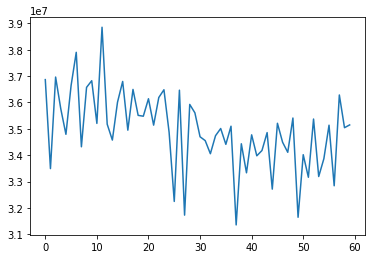

In [0]:
summed_q = np.sum(qq,axis = 0)
plt.plot(summed_q)

In [0]:
X = np.arange(0,60,1)
y = summed_q/1E7
fit2 = UnivariateSpline(X,y, k =5)

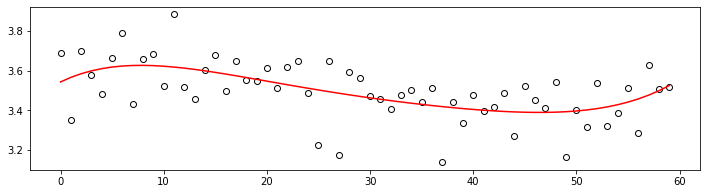

In [0]:
plt.figure(figsize = (12,3))
plt.plot(X,y,"o",color = "black",fillstyle = "none")
plt.plot(X,fit2(X),"-",color = "red",fillstyle = "none")

# Dementia

## Find the codes of drugs used in dementia.

In [0]:
dementia_drugs = ["Donepezil","Aricept","Rivastigmine","Exelon","Galantamine","Reminyl"]

In [0]:
code_names = np.load("working_dir/saved_arrays/code_chemical.npy")

In [0]:
code = code_names[0]
chemical = code_names[1]

In [0]:
code

array([' (0101010C0)', ' (0101010E0)', ' (0101010F0)', ..., ' (2396)',
       ' (2398)', ' (2399)'], dtype='<U40')

In [0]:
dementia_chems = []
#loop through all drugs:
for c in chemical:
  #create a regular expression
  if c == "":
    continue
  try:  
    re_temp = re.compile(".*"+str(c)+".*")
    #print(re_temp)
  except:
    continue
  for drug,c1 in zip(dementia_drugs,code):
    try:
      p = re_temp.match(drug).group()
      print(p)
      dementia_chems.append((drug,c1))
    except:
      pass

Rivastigmine
Galantamine


In [0]:
code_to_chem_dementia = {}
for name,code in dementia_chems:
  code = code.replace("(","")
  code = code.replace(")","")
  code = code.replace(" ","")
  code_to_chem_dementia[code] = name

In [0]:
code_to_chem_dementia

{'0101010F0': 'Rivastigmine', '0101010I0': 'Galantamine'}

## Make a Dictionary

In [0]:
#we can now try to do this for all available chemicals
codes = code_to_chem_dementia.keys()
dementia_data_dict = {}

for c in codes:

  actual_cost,date,items,quantity = read_chemical(c)

  if date == None:
    next
  else:
    temp_dict = {}
    temp_dict["actual_cost"] = actual_cost                                                 
    temp_dict["date"] = date              
    temp_dict["items"] = items
    temp_dict["quantity"] =   quantity                                   
    dementia_data_dict[c] = temp_dict



200
200


In [0]:
dementia_data_dict

{'0101010F0': {'actual_cost': ['9296.25',
   '10232.21',
   '12791.64',
   '10910.52',
   '6793.53',
   '13305.41',
   '10479.79',
   '8453.01',
   '11390.09',
   '8279.13',
   '6134.33',
   '9098.89',
   '7813.47',
   '11739.39',
   '10789.76',
   '8250.0',
   '7797.05',
   '8665.31',
   '9719.89',
   '7970.5',
   '11521.88',
   '7728.76',
   '7787.07',
   '10364.42',
   '8442.58',
   '10111.02',
   '8802.27',
   '7545.01',
   '5589.42',
   '8662.25',
   '8801.03',
   '10056.17',
   '8644.17',
   '9739.77',
   '8710.59',
   '7227.33',
   '6396.34',
   '6163.26',
   '10440.65',
   '3493.48',
   '11317.97',
   '8398.65',
   '5230.79',
   '4127.82',
   '7593.86',
   '8936.35',
   '10420.41',
   '8140.59',
   '4554.59',
   '4110.52',
   '6959.28',
   '8528.78',
   '8020.69',
   '8327.76',
   '7498.19',
   '8306.65',
   '8673.7',
   '8741.49',
   '6249.23',
   '6941.12'],
  'date': ['2015-01-01',
   '2015-02-01',
   '2015-03-01',
   '2015-04-01',
   '2015-05-01',
   '2015-06-01',
   '2015-

In [0]:
qlist = []
i = -1
for chemical in dementia_data_dict.keys():
  i+=1
  value_dict = dementia_data_dict[chemical]
  qlist.append(np.array(value_dict["quantity"]))

qq = np.vstack(qlist)

Text(0.5, 0, '')

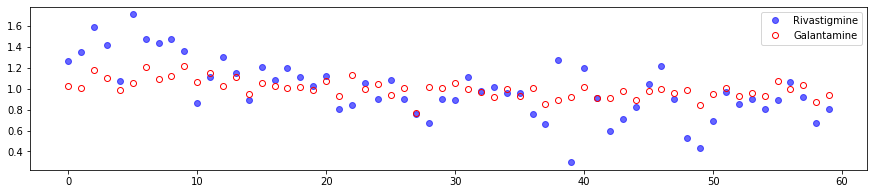

In [0]:
R = qq[0]/np.mean(qq[0])
G = qq[1]/np.mean(qq[1])

plt.figure(figsize=(15,3))
plt.plot(R,"o",label = "Rivastigmine",color = "blue",alpha = 0.6)#,fillstyle = "none")
plt.plot(G,"o",label = "Galantamine",color = "red",fillstyle = "none")
plt.legend()
plt.xlabel("")

In [0]:
np.save("working_dir/saved_arrays/dementia_drups",qq)